<a href="https://colab.research.google.com/github/Shayankr/Speech_Technology/blob/master/Speech_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Project_1</center>

Shayan Kumar
224102319

`Perform DTW based isolated vowel recognition`

For each of the vowels, choose one of the utterance as the reference template and the remaining ones as the test templates. Compute 39-dimensional MFCC features comprising base, delta, and delta-delta components for all the recordings using MATLAB. Using DTW command of MATLAB, write a script that computes DTW scores for any two similar or dissimilar test utterances and also plots the corresponding DTW curve.

In [ ]:
#!pip install dtw

In [2]:
# importing libraries:
import numpy as np
import cmath
import os
from scipy.io import wavfile
import scipy.io
import librosa
import librosa.display
import dtw
from dtw import dtw
from numpy.linalg import norm
import soundfile
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#  test one audio clip
audio_signal, sampling_rate = soundfile.read(r"/content/drive/MyDrive/Speech_project/Recording_Shayan/vowel_a/224102319_a_01.wav")
print('Audio duration: {} seconds'.format(audio_signal.size / sampling_rate))

Audio duration: 2.34 seconds


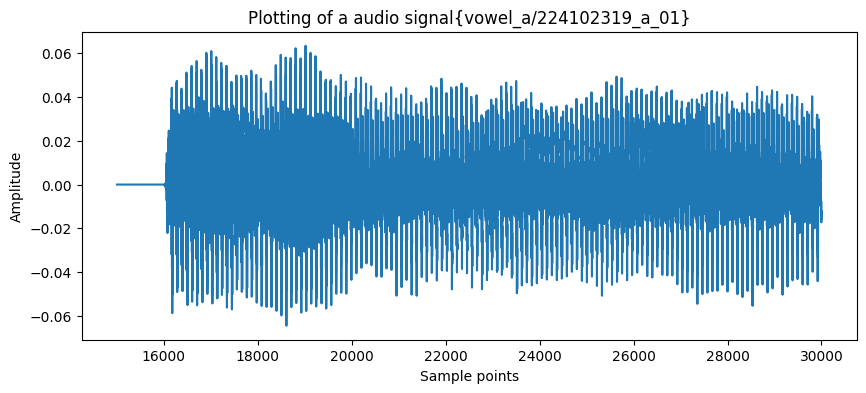

In [5]:
plt.figure(figsize=(10,4))
plt.plot(range(15000,30000),audio_signal[15000:30000])
plt.xlabel("Sample points")
plt.ylabel("Amplitude")
plt.title("Plotting of a audio signal{vowel_a/224102319_a_01}")
plt.show()

In [6]:
type(audio_signal)

numpy.ndarray

In [7]:
!nvidia-smi

Sun May 14 10:33:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Computing 39 dim MFCCs coeff: (base, delta, delta-delta)

In [8]:
# Define the file path
data_path = r"/content/drive/MyDrive/Speech_project/Recording_Shayan/"

#### Defining Feature Extraxtion

In [9]:
# Define the number of MFCC coefficients
n_mfcc = 13
n_fft = 512
win_length = 480   # To obtain 30 ms window
hop_length = 160   # 10 ms shift between consecutive windows

# Define function to extract MFCC, delta, and delta-delta features
def extract_features(file_path):
    audio_signal, sampling_rate = librosa.load(file_path, sr=16000)
    # Normalizing time domain signal:
    audio_signal = audio_signal / np.max(np.abs(audio_signal))

    # Compute the MFCCs
    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sampling_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    # Feature normalization:
    mfccs = librosa.util.normalize(mfccs)

    # Compute delta and delta-delta features
    delta_mfccs = librosa.feature.delta(mfccs)
    delta_mfccs = librosa.util.normalize(delta_mfccs)

    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    delta2_mfccs = librosa.util.normalize(delta2_mfccs)

    # Concatenate features
    features = np.concatenate([mfccs, delta_mfccs, delta2_mfccs], axis=0)

    return features


In [10]:
# Define the vowels and keys and their utterances
vowels = ['a', 'e', 'i', 'o', 'u']
reference_utterance_index = 0
keys = ['vowel_' + vowel for vowel in vowels]#

In [11]:
# Initialize dictionary to store features for each vowel and utterance
vowel_features = {key: [] for key in keys}

#### Extracting features vowel-wise

In [12]:
# Extract and store features for each vowel and utterance
data_path = r"/content/drive/MyDrive/Speech_project/Recording_Shayan/"
for i,key in enumerate(keys):
    for j in range(1, 26):
        file_path = os.path.join(data_path, key, '224102319_'+ vowels[i] + '_{:02d}.wav'.format(j))
        features = extract_features(file_path)
        vowel_features[key].append(features)

In [13]:
vowel_features["vowel_a"][24].shape

(39, 232)

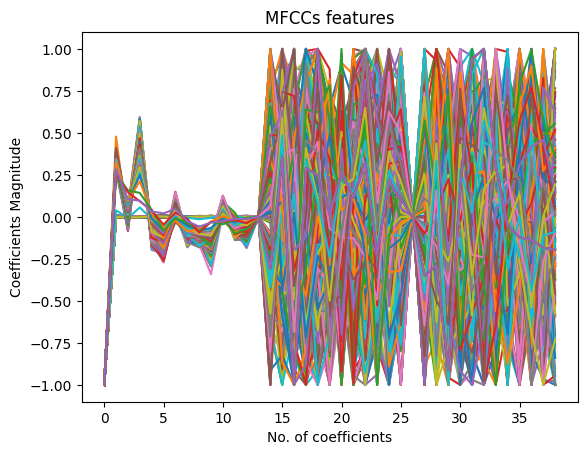

In [14]:
plt.plot(figsize=(18,4))
plt.plot(vowel_features["vowel_a"][0]);
plt.title("Normalized MFCCs features for vowel_a")
plt.title("MFCCs features")
plt.ylabel("Coefficients Magnitude")
plt.xlabel("No. of coefficients")
plt.show()


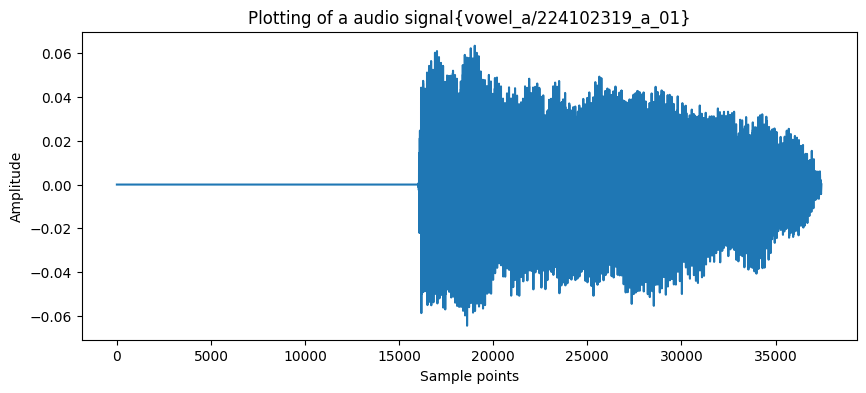

In [15]:
audio_signal, sampling_rate = soundfile.read(r"/content/drive/MyDrive/Speech_project/Recording_Shayan/vowel_a/224102319_a_01.wav")
plt.figure(figsize=(10,4))
plt.plot(audio_signal)
plt.xlabel("Sample points")
plt.ylabel("Amplitude")
plt.title("Plotting of a audio signal{vowel_a/224102319_a_01}")
plt.show()

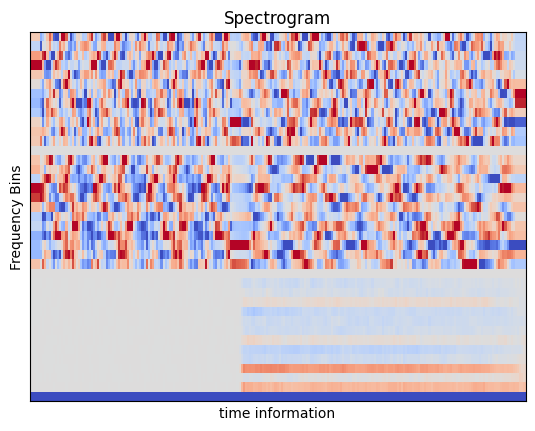

In [16]:
plt.figure()
librosa.display.specshow(vowel_features["vowel_a"][0])
plt.title("Spectrogram")
plt.ylabel("Frequency Bins")
plt.xlabel("time information")
plt.show()

### Performing DTW

In [17]:
# Define function to compute DTW score and plot DTW curve
def compute_dtw(reference_path, test_path):
    # Extract features from reference and test files
    ref_features = extract_features(reference_path)
    test_features = extract_features(test_path)

    # Compute DTW distance and path
    dist, cost, acc_cost, path = dtw(ref_features.T, test_features.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
    print(dist)
    # Plot DTW curve
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.imshow(cost.T, origin='lower', cmap=plt.cm.gray, interpolation='nearest')
    ax.plot(path[0], path[1], 'w', linewidth=2)
    ax.set_xlim((-0.5, cost.shape[0]-0.5))
    ax.set_ylim((-0.5, cost.shape[1]-0.5))
    plt.show()


* vowels = ['a', 'e', 'i', 'o', 'u']
* reference_utterance_index = 0
* keys = ['vowel_' + vowel for vowel in vowels]


Performing DTW with Similar Utterances: 

Computing DTW score for vowel_a: vowel_a_01 vs vowel_a_15
2072.255475997925


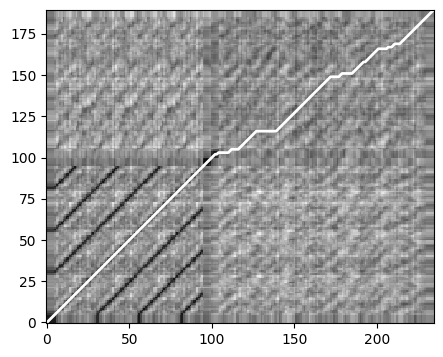


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_a: vowel_a_01 vs vowel_e_09
1891.3936015963554


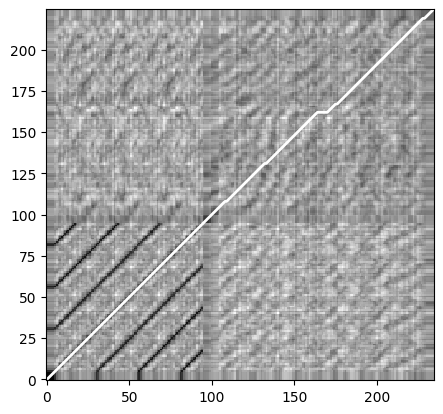


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_a: vowel_a_01 vs vowel_i_13
4112.947048187256


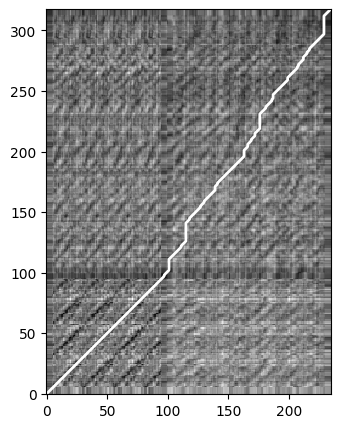


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_a: vowel_a_01 vs vowel_o_03
2831.7222018241882


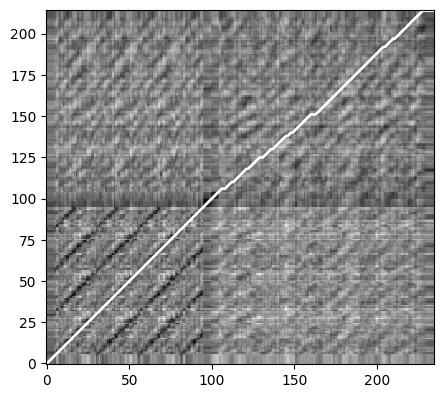


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_a: vowel_a_01 vs vowel_u_08
3433.1738936901093


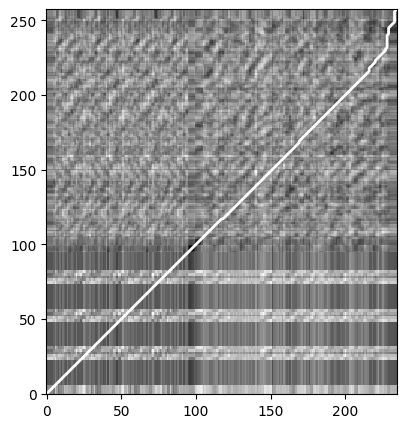


Performing DTW with Similar Utterances: 

Computing DTW score for vowel_e: vowel_e_01 vs vowel_e_25
2880.943001270294


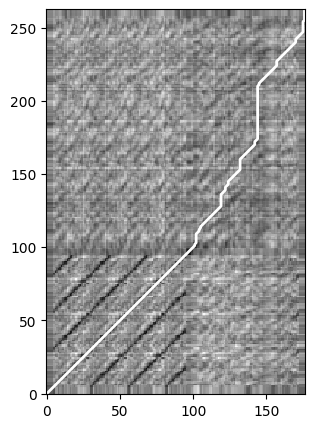


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_e: vowel_e_01 vs vowel_a_18
1801.0681385993958


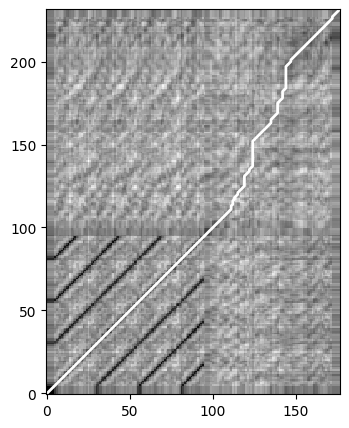


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_e: vowel_e_01 vs vowel_i_02
3696.9052414894104


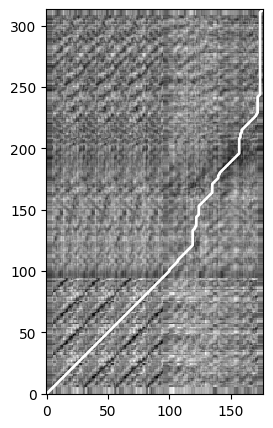


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_e: vowel_e_01 vs vowel_o_04
1963.55617749691


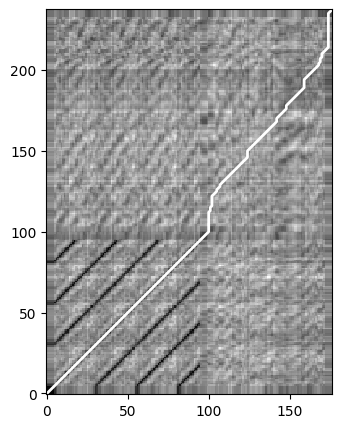


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_e: vowel_e_01 vs vowel_u_01
3313.2958664894104


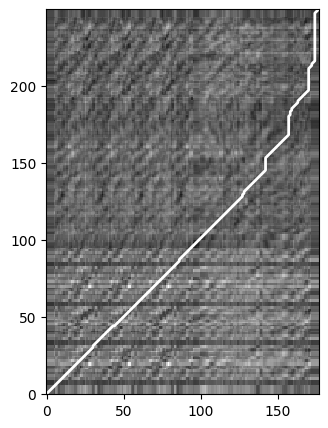


Performing DTW with Similar Utterances: 

Computing DTW score for vowel_i: vowel_i_01 vs vowel_i_22
3152.3641923857795


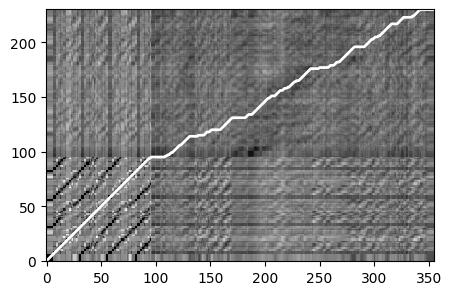


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_i: vowel_i_01 vs vowel_a_14
4687.447637081146


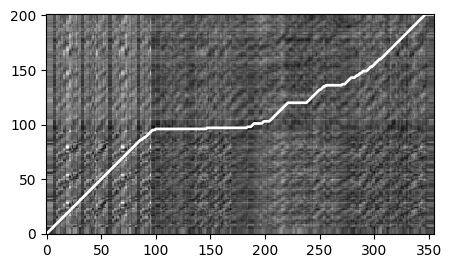


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_i: vowel_i_01 vs vowel_e_02
3364.406093438418


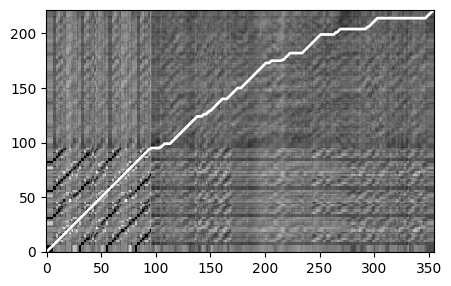


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_i: vowel_i_01 vs vowel_o_16
4285.844160782428


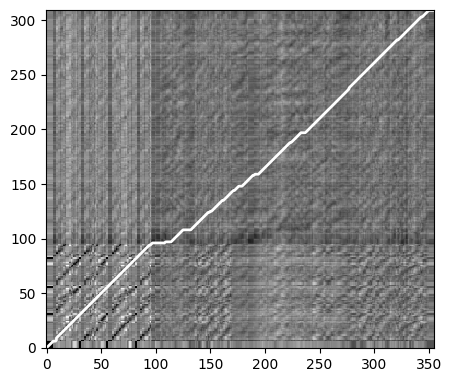


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_i: vowel_i_01 vs vowel_u_21
4454.207214355469


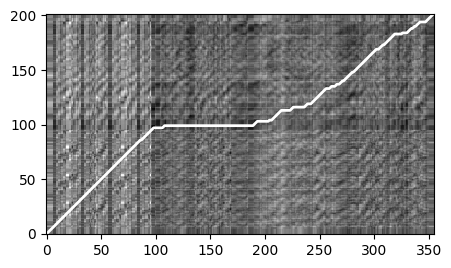


Performing DTW with Similar Utterances: 

Computing DTW score for vowel_o: vowel_o_01 vs vowel_o_20
2517.980977535248


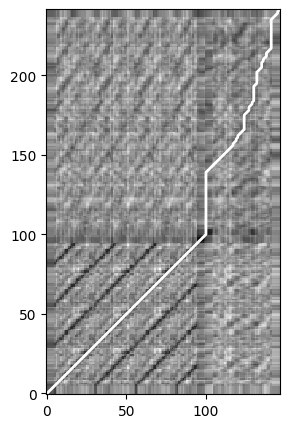


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_o: vowel_o_01 vs vowel_a_16
1774.2409265041351


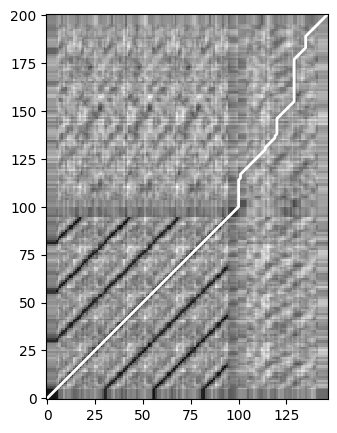


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_o: vowel_o_01 vs vowel_e_12
2545.0053465366364


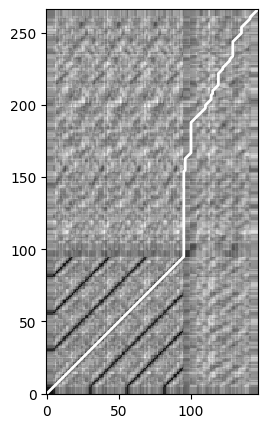


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_o: vowel_o_01 vs vowel_i_22
3219.6076641082764


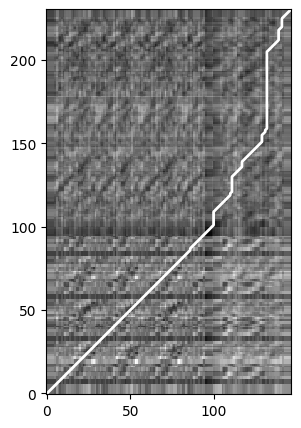


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_o: vowel_o_01 vs vowel_u_21
1239.3246261775494


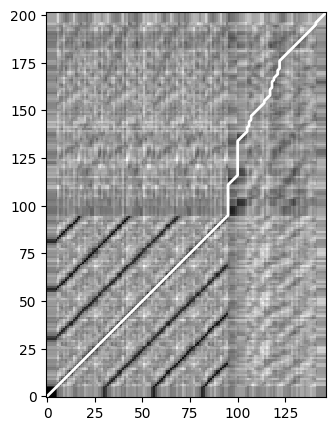


Performing DTW with Similar Utterances: 

Computing DTW score for vowel_u: vowel_u_01 vs vowel_u_23
2110.005749164018


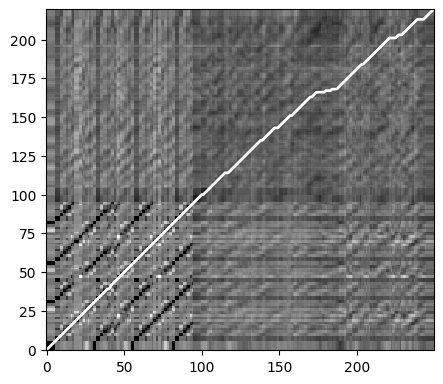


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_u: vowel_u_01 vs vowel_a_25
3597.371159553528


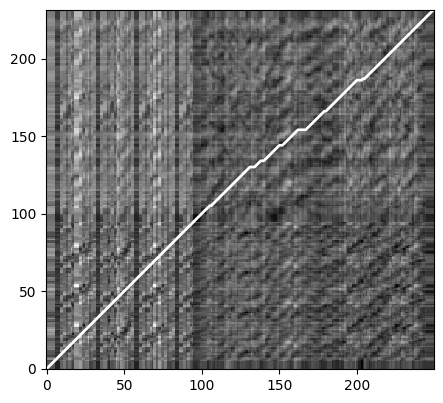


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_u: vowel_u_01 vs vowel_e_22
4146.2318902528095


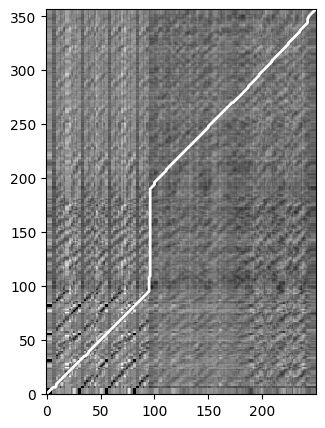


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_u: vowel_u_01 vs vowel_i_17
3311.170151233673


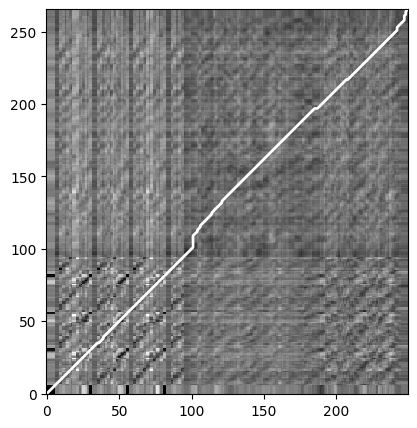


Performing DTW with DiSimilar Utterances: 

Computing DTW score for vowel_u: vowel_u_01 vs vowel_o_15
2885.0949569051736


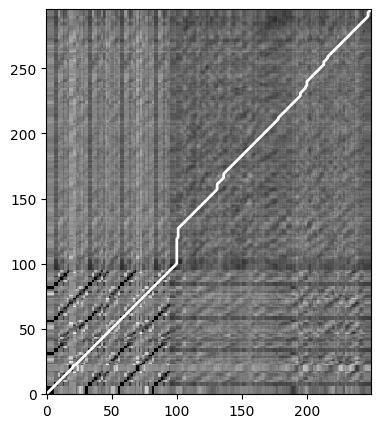

In [18]:
data_path = r"/content/drive/MyDrive/Speech_project/Recording_Shayan/"
import random 

# Iterate over vowels and compute DTW for each
for i, key in enumerate(keys):
    # Define the reference file
    ref_file = os.path.join(data_path, key, '224102319_'+ vowels[i] + '_01.wav')
    print(f"\nPerforming DTW with Similar Utterances: \n")
    num = random.randint(2, 25)
    print('Computing DTW score for {}: {} vs {}'.format(key, key + '_01', key + '_{:02d}'.format(num)))
    test_file = os.path.join(data_path, key, '224102319_'+ vowels[i] + '_{:02d}.wav'.format(num))
    compute_dtw(ref_file, test_file)


    # Iterate over the test files of disimilar utterances
    for j,key_test in enumerate(keys):
        if key_test != key:
            num_test=random.randint(1, 25)
            test_file = os.path.join(data_path, key_test, '224102319_'+ vowels[j] + '_{:02d}.wav'.format(num_test))

            # Compute DTW score and plot DTW curve
            print(f"\nPerforming DTW with DiSimilar Utterances: \n")
            print('Computing DTW score for {}: {} vs {}'.format(key, key + '_01', key_test + '_{:02d}'.format(num_test)))
            compute_dtw(ref_file, test_file)


##END